In [1]:
import os
import numpy as np
import torch
import pandas as pd
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, periodogram
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis
from torch.utils.data import random_split
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import gc
from sklearn.metrics import r2_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)

Using Device: cuda


In [2]:
# Noise Filters
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = fs / 2.0
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=1.0, highcut=200.0, fs=1000.0, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data, axis=0)

# Apply after bandpass
def notch_filter(data, freq=60.0, fs=1000.0, quality=30.0):
    b, a = iirnotch(freq, quality, fs)
    return filtfilt(b, a, data, axis=0)

# Noise Metrics for evaluation
def compute_rmse(true, estimate):
    return np.sqrt(np.mean((true - estimate) ** 2))

def compute_spectral_flatness_band(signal, fs, band):
    f, Pxx = periodogram(signal, fs=fs)
    idx = (f >=band[0]) & (f <=band[1])
    Pxx = Pxx[idx] + 1e-12
    gm = np.exp(np.mean(np.log(Pxx)))
    am = np.mean(Pxx)
    return gm / am

mu_band = (8, 13)
beta_band = (13, 30)
hg_band = (70, 200)

# Kurtosis signal reduction > 0 shows a denoised signal
def proportion_of_positive_kurtosis_signals(kurtosis_raw, kurtosis_denoised):
    return (np.array([(kurtosis_raw - kurtosis_denoised) > 0]).sum() / len(kurtosis_raw)) * 100

# Use a Standard scaler to reduce the mean to 0 and std to 1

In [3]:
# Model definitions
class EcogMotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
# CNN/LSTM hybrid
class EcogToMotionNet(nn.Module):
    def __init__(self):
        super().__init__()

        # CNN component: outputs 256 channels
        self.convolv = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding=1),  # Fixed to 256 channels
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )

        # LSTM component
        self.lstm = nn.LSTM(input_size=256, hidden_size=128, num_layers=1, batch_first=True)

        # Fully connected layer
        self.fc = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(128, 3)  # Matches hidden_size=128
        )

    def forward(self, x):
        # Input shape: (batch, 20, 64)
        x = x.permute(0, 2, 1)  # Shape: (batch, 64, 20)
        x = self.convolv(x)      # Shape: (batch, 256, 20)
        x = x.permute(0, 2, 1)   # Shape: (batch, 20, 256)
        lstm_out, (h_n, c_n) = self.lstm(x)  # lstm_out shape: (batch, 20, 128)
        last_output = lstm_out[:, -1, :]     # Shape: (batch, 128)
        output = self.fc(last_output)        # Shape: (batch, 3)
        return output

# Linear Model
class LinearEcogToMotionNet(nn.Module):
    def __init__(self, input_channels = 64, sequence_length = 20, output_dim = 3):
        super().__init__()
        self.linear = nn.Linear(input_channels * sequence_length, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = x.flatten(start_dim=1)
        x = self.linear(x)
        return x

# LSTM
class EcogLSTM(nn.Module):
    def __init__(self, input_size = 64, hidden_size = 128, num_layers = 1, output_size = 3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x) # lstm_out shape: (batch_size, seq_len, hidden_size)
        last_output = lstm_out[:, -1, :]
        output = self.fc(last_output)
        return output
 

In [5]:
class PreprocessData:
    def __init__(self, ecog_file_path, motion_file_path):
        self.ecog_file_path = ecog_file_path
        self.motion_file_path = motion_file_path
        self.ecog_data = None
        self.motion_data = None
        self.filtered_ecog = None
        self.scaled_ecog = None
        self.X = None
        self.y = None

    def process(self, eval=False, window_size=20, duration_limit=900):
        self.read_data()
        self.filter_signal(eval=eval)
        self.format_data(window_size=window_size, duration_limit=duration_limit)
        return self.X, self.y
    
    def read_data(self):
        self.ecog_data = pd.read_csv(self.ecog_file_path)
        self.motion_data = pd.read_csv(self.motion_file_path)
        return self

    def filter_signal(self, eval=False):
        ecog_raw = self.ecog_data[self.ecog_data.columns[1:-1]].values

        # Apply filters
        filtered = bandpass_filter(ecog_raw, lowcut=1.0, highcut=200.0, fs=1000.0, order=4)
        denoised = notch_filter(filtered, freq=60, fs=1000.0)

        # Evaluate filters
        if eval:
            kurt_raw = kurtosis(ecog_raw, axis=0, fisher=True)
            kurt_denoised = kurtosis(denoised, axis=0, fisher=True)
            proportion_of_positive_kurtosis_signals(kurt_raw, kurt_denoised)
            compute_rmse(ecog_raw, denoised)

        # Scale
        scaler = StandardScaler()
        self.scaled_ecog = scaler.fit_transform(denoised)

        # Replace in DataFrame
        self.ecog_data = self.ecog_data.copy()
        self.ecog_data[self.ecog_data.columns[1:-1]] = self.scaled_ecog

        # Clean memory
        del ecog_raw, filtered, denoised
        gc.collect()
        return self

    def format_data(self, window_size=20, duration_limit=900):
        ecog_df = self.ecog_data[self.ecog_data["Time"] <= duration_limit]
        motion_df = self.motion_data[self.motion_data["Motion_time"] <= duration_limit]

        ecog_values = ecog_df[ecog_df.columns[1:-1]].values
        motion_values = motion_df[motion_df.columns[2:]].values

        num_windows = motion_values.shape[0]

        # Create sliding windows
        self.X = np.stack([
            ecog_values[i*window_size:(i+1)*window_size]
            for i in range(num_windows)
        ])
        self.y = motion_values[:num_windows]
        
        # Clean up
        del ecog_values, motion_values
        gc.collect()

    def save(self):
        output_file_path_base = self.ecog_file_path.strip("ecog_data.csv")
        np.save(output_file_path_base + "X.npy", self.X)
        np.save(output_file_path_base + "y.npy", self.y)


In [26]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=20, early_stopping_patience=5, model_name="model", scheduler=None):
    model.to(device)
    best_val_loss = float('inf')
    best_epoch = 0
    
    train_losses = []
    val_losses = []
    r2_scores = []
    
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * X_batch.size(0)
        avg_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        model.eval()
        running_val_loss = 0.0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                preds = model(X_batch)
                loss = criterion(preds, y_batch)
                running_val_loss += loss.item() * X_batch.size(0)
                all_preds.append(preds.cpu())
                all_targets.append(y_batch.cpu())
        all_preds = torch.cat(all_preds).numpy()
        all_targets = torch.cat(all_targets).numpy()
        r2 = r2_score(all_targets, all_preds)
        r2_scores.append(r2)
        avg_val_loss = running_val_loss / len(val_loader.dataset)
        if scheduler is not None:
            scheduler.step(avg_val_loss)
        val_losses.append(avg_val_loss)
        
        print(f"{model_name} Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | R2: {r2:.6f}")
        

        # Save best model checkpoint
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), f"{model_name}_best.pth")
        
        # Early stopping
        if epoch - best_epoch >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    return train_losses, val_losses

def plot_losses(losses_dict):
    plt.figure(figsize=(10,6))
    for model_name, (train_losses, val_losses) in losses_dict.items():
        plt.plot(train_losses, label=f"{model_name} Train")
        plt.plot(val_losses, label=f"{model_name} Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.show()


In [7]:
os.path.join(os.getcwd(), "src/", "motor_cortex/data/")

'/home/linux-pc/gh/CRCNS/src/motor_cortex/data/'

In [8]:
motion_data_file_l = glob(os.path.join(os.getcwd(), "src/", "motor_cortex/data/data/", "**", "motion*.csv"), recursive=True)
ecog_data_file_l = glob(os.path.join(os.getcwd(), "src/", "motor_cortex/data/data/", "**", "ecog*.csv"), recursive=True)

# Reading only the Right Wrist data and training to detect depending on the Right Wrist

## Bilateral Data

In [ ]:
motion_data_file_l[0]

In [ ]:
motion_data_file = motion_data_file_l[0]

In [ ]:
ecog_data_file = ecog_data_file_l[0]

In [ ]:
motion_data_file

In [ ]:
ecog_data_file

In [ ]:
motion_data_bilateral_2018_07_12_S1 = pd.read_csv(motion_data_file)

In [ ]:
motion_data_bilateral_2018_07_12_S1["Motion_time"]

In [ ]:
ecog_data_bilateral_2018_07_12_S1 = pd.read_csv(ecog_data_file)
channel_data = ecog_data_bilateral_2018_07_12_S1.columns[1:-1].values
ecog_data_bilateral_2018_07_12_S1[channel_data].values

In [ ]:
ecog_data_bilateral_2018_07_12_S1["Time"]

In [ ]:
plt.plot(ecog_data_bilateral_2018_07_12_S1["Time"], ecog_data_bilateral_2018_07_12_S1[channel_data].values)

In [ ]:
ecog_channels = ecog_data_bilateral_2018_07_12_S1.columns[1:-1]

In [ ]:
ecog_data_bilateral_2018_07_12_S1[ecog_channels].values

In [ ]:
motion_data_bilateral_2018_07_12_S1_left_wrist = motion_data_bilateral_2018_07_12_S1[motion_data_bilateral_2018_07_12_S1.columns[1:4]]

In [ ]:
motion_data_bilateral_2018_07_12_S1_left_wrist

In [ ]:
motion_data_bilateral_2018_07_12_S1_left_wrist

In [ ]:
ecog_data_bilateral_2018_07_12_S1[channel_data]

In [ ]:
del ecog_data_bilateral_2018_07_12_S1

## Ipsilateral Data (Right Wrist)

In [9]:
ecog_data_file_l[6]

'/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-10_(S7)/ecog_data.csv'

In [10]:
ecog_data_file_l[6]

'/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-10_(S7)/ecog_data.csv'

In [ ]:
# current_ecog_data_file = ecog_data_file_l[6]
# current_motion_data_file = motion_data_file_l[6]
# preprocessor = PreprocessData(current_ecog_data_file, current_motion_data_file)
# X, y = preprocessor.process()
# preprocessor.save()

KeyboardInterrupt: 

In [ ]:
# Preprocess Ipsilateral Data
# for index in range(6, 16):
#     preprocessor = PreprocessData(ecog_data_file_l[index], motion_data_file_l[index])
#     X, y = preprocessor.process()
#     preprocessor.save()

KeyboardInterrupt: 

In [11]:
ecog_data_file_l[16:ecog_data_file_l.__len__()]

['/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Contralateral/2018-03-15_(S1)/ecog_data.csv',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Contralateral/2018-04-12_(S3)/ecog_data.csv',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Contralateral/2018-04-08_(S2)/ecog_data.csv',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Contralateral/2018-04-22_(S7)/ecog_data.csv',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Contralateral/2018-04-12_(S4)/ecog_data.csv',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Contralateral/2018-04-22_(S9)/ecog_data.csv',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Contralateral/2018-04-12_(S5)/ecog_data.csv',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Contralateral/2018-04-22_(S8)/ecog_data.csv',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Contralateral/2018-05-31_(S10)/ecog_data.csv',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Contralateral/2018-04-15_(S6)/ecog_data.csv']

In [ ]:
# # Preprocess Contralateral Data
# for index in range(16, ecog_data_file_l.__len__()):
#     preprocessor = PreprocessData(ecog_data_file_l[index], motion_data_file_l[index])
#     X, y = preprocessor.process()
#     preprocessor.save()

In [12]:
# Read in the data
processed_data_l_X = glob(os.path.join('/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/', '**', "**", "X.npy"))
processed_data_l_y = glob(os.path.join('/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/', '**', "**", "y.npy"))

In [13]:
processed_data_l_X

['/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-10_(S7)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-24_(S10)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-04-29_(S1)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-06_(S6)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-03_(S5)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-03_(S3)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-03_(S4)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-10_(S8)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-17_(S9)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-04-29_(S2)/X.npy']

In [14]:
processed_data_l_y

['/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-10_(S7)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-24_(S10)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-04-29_(S1)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-06_(S6)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-03_(S5)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-03_(S3)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-03_(S4)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-10_(S8)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-17_(S9)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-04-29_(S2)/y.npy']

In [87]:
# # Perform K-Fold Cross Validation
# iterator = iter(processed_data_l)

# for X, y in zip(iterator, iterator):
#     print(X)
#     print(y)

# Create k-fold cross validation
# select the best model
# make a prediction
# visualize the predictions in matlab
# create a live demo
# deploy demo onto the web
# share results for testing with real people


In [15]:
# Define K-fold sets
test_list_X = []
train_list_X = []
test_list_y = []
train_list_y = []

for i in range(len(processed_data_l_X)):
    test_list_X.append(processed_data_l_X[i])
    test_list_y.append(processed_data_l_y[i])
    train_X = [x for idx, x in enumerate(processed_data_l_X) if idx != i]
    train_y = [y for idx, y in enumerate(processed_data_l_y) if idx != i]
    train_list_X.append(train_X)
    train_list_y.append(train_y)

In [16]:
INDEX = 0

In [17]:
X = np.load(train_list_X[INDEX][0])
y = np.load(train_list_y[INDEX][0])

In [18]:
X.shape

(44989, 20, 64)

In [19]:
y.shape

(44989, 3)

In [20]:
# Creating Train and Validation Sets
dataset = EcogMotionDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

In [21]:
# Defining the model

# Train Linear Model
input_channels = X.shape[2]
sequence_length = X.shape[1]
model = LinearEcogToMotionNet(input_channels, sequence_length)

# Train 1D CNN
# model = EcogToMotionNet()

# Train LSTM
# model = EcogLSTM(input_size=64, hidden_size=128, num_layers=1, output_size=3)


## Linear Model

In [118]:
# Linear Model 

# Train Linear Model
input_channels = X.shape[2]
sequence_length = X.shape[1]
linear_model = LinearEcogToMotionNet(input_channels, sequence_length)

linear_model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(linear_model.parameters(), lr=1e-3)

# Training loop
for epoch in range(20):
    linear_model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        preds = linear_model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    linear_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            preds = linear_model(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item() * X_batch.size(0)
        val_loss /= len(val_loader.dataset)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val.Loss: {val_loss:.4f}")

Epoch 1 | Train Loss: 1.0769 | Val.Loss: 1.0425
Epoch 2 | Train Loss: 1.0670 | Val.Loss: 1.0912
Epoch 3 | Train Loss: 1.0628 | Val.Loss: 1.0493
Epoch 4 | Train Loss: 1.0661 | Val.Loss: 1.0837
Epoch 5 | Train Loss: 1.0581 | Val.Loss: 1.0499
Epoch 6 | Train Loss: 1.0566 | Val.Loss: 1.1074
Epoch 7 | Train Loss: 1.0686 | Val.Loss: 1.0719
Epoch 8 | Train Loss: 1.0677 | Val.Loss: 1.0536
Epoch 9 | Train Loss: 1.0560 | Val.Loss: 1.0878
Epoch 10 | Train Loss: 1.0602 | Val.Loss: 1.0627
Epoch 11 | Train Loss: 1.0574 | Val.Loss: 1.0796
Epoch 12 | Train Loss: 1.0553 | Val.Loss: 1.0486
Epoch 13 | Train Loss: 1.0602 | Val.Loss: 1.0814
Epoch 14 | Train Loss: 1.0547 | Val.Loss: 1.0619
Epoch 15 | Train Loss: 1.0564 | Val.Loss: 1.0507
Epoch 16 | Train Loss: 1.0573 | Val.Loss: 1.0746
Epoch 17 | Train Loss: 1.0554 | Val.Loss: 1.1448
Epoch 18 | Train Loss: 1.0580 | Val.Loss: 1.0960
Epoch 19 | Train Loss: 1.0553 | Val.Loss: 1.1393
Epoch 20 | Train Loss: 1.0613 | Val.Loss: 1.0804


## Convolutional Neural Network

In [18]:
# Train 1D CNN
cnn_model = EcogToMotionNet()

cnn_model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)

# Training loop
for epoch in range(20):
    cnn_model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        preds = cnn_model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    cnn_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            preds = cnn_model(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item() * X_batch.size(0)
        val_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val.Loss: {val_loss:.4f}")

Epoch 1 | Train Loss: 0.9920 | Val.Loss: 0.2579
Epoch 2 | Train Loss: 0.9682 | Val.Loss: 0.2520
Epoch 3 | Train Loss: 0.9553 | Val.Loss: 0.2561
Epoch 4 | Train Loss: 0.9446 | Val.Loss: 0.2527
Epoch 5 | Train Loss: 0.9353 | Val.Loss: 0.2450
Epoch 6 | Train Loss: 0.9261 | Val.Loss: 0.2440
Epoch 7 | Train Loss: 0.9204 | Val.Loss: 0.2439
Epoch 8 | Train Loss: 0.9123 | Val.Loss: 0.2433
Epoch 9 | Train Loss: 0.9097 | Val.Loss: 0.2416
Epoch 10 | Train Loss: 0.9020 | Val.Loss: 0.2387
Epoch 11 | Train Loss: 0.8989 | Val.Loss: 0.2417
Epoch 12 | Train Loss: 0.8953 | Val.Loss: 0.2400
Epoch 13 | Train Loss: 0.8896 | Val.Loss: 0.2375
Epoch 14 | Train Loss: 0.8870 | Val.Loss: 0.2445
Epoch 15 | Train Loss: 0.8855 | Val.Loss: 0.2390
Epoch 16 | Train Loss: 0.8832 | Val.Loss: 0.2387
Epoch 17 | Train Loss: 0.8792 | Val.Loss: 0.2378
Epoch 18 | Train Loss: 0.8747 | Val.Loss: 0.2372
Epoch 19 | Train Loss: 0.8728 | Val.Loss: 0.2359
Epoch 20 | Train Loss: 0.8715 | Val.Loss: 0.2355


## Long Short-Term Memory Model

In [207]:
lstm_model = EcogLSTM(input_size=64, hidden_size=128, num_layers=1, output_size=3)
lstm_model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

# Training loop
for epoch in range(20):
    lstm_model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        preds = lstm_model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    lstm_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            preds = lstm_model(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item() * X_batch.size(0)
        val_loss /= len(val_loader.dataset)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val.Loss: {val_loss:.4f}")

Epoch 1 | Train Loss: 1.0020 | Val.Loss: 0.9884
Epoch 2 | Train Loss: 0.9697 | Val.Loss: 0.9664
Epoch 3 | Train Loss: 0.9395 | Val.Loss: 0.9427
Epoch 4 | Train Loss: 0.9096 | Val.Loss: 0.9568
Epoch 5 | Train Loss: 0.8788 | Val.Loss: 0.9366
Epoch 6 | Train Loss: 0.8429 | Val.Loss: 0.9287
Epoch 7 | Train Loss: 0.8062 | Val.Loss: 0.9435
Epoch 8 | Train Loss: 0.7639 | Val.Loss: 0.9770
Epoch 9 | Train Loss: 0.7134 | Val.Loss: 0.9351
Epoch 10 | Train Loss: 0.6753 | Val.Loss: 0.9574
Epoch 11 | Train Loss: 0.6273 | Val.Loss: 0.9840
Epoch 12 | Train Loss: 0.5923 | Val.Loss: 0.9928
Epoch 13 | Train Loss: 0.5456 | Val.Loss: 0.9715
Epoch 14 | Train Loss: 0.5127 | Val.Loss: 0.9826
Epoch 15 | Train Loss: 0.4877 | Val.Loss: 1.0007
Epoch 16 | Train Loss: 0.4565 | Val.Loss: 1.0444
Epoch 17 | Train Loss: 0.4305 | Val.Loss: 1.0313
Epoch 18 | Train Loss: 0.4180 | Val.Loss: 1.0267
Epoch 19 | Train Loss: 0.3837 | Val.Loss: 1.0373
Epoch 20 | Train Loss: 0.3853 | Val.Loss: 1.0555


## Training All Models

CNN Epoch 1/40 | Train Loss: 0.999043 | Val Loss: 0.996034 | R2: 0.027387
CNN Epoch 2/40 | Train Loss: 0.982132 | Val Loss: 0.982891 | R2: 0.040173
CNN Epoch 3/40 | Train Loss: 0.969622 | Val Loss: 0.992586 | R2: 0.030730
CNN Epoch 4/40 | Train Loss: 0.963649 | Val Loss: 0.966182 | R2: 0.056499
CNN Epoch 5/40 | Train Loss: 0.953402 | Val Loss: 0.956021 | R2: 0.066407
CNN Epoch 6/40 | Train Loss: 0.934915 | Val Loss: 0.952391 | R2: 0.069921
CNN Epoch 7/40 | Train Loss: 0.930235 | Val Loss: 0.942530 | R2: 0.079572
CNN Epoch 8/40 | Train Loss: 0.915230 | Val Loss: 0.925923 | R2: 0.095759
CNN Epoch 9/40 | Train Loss: 0.905086 | Val Loss: 0.928259 | R2: 0.093497
CNN Epoch 10/40 | Train Loss: 0.892438 | Val Loss: 0.948972 | R2: 0.073283
CNN Epoch 11/40 | Train Loss: 0.883355 | Val Loss: 0.919942 | R2: 0.101608
CNN Epoch 12/40 | Train Loss: 0.873627 | Val Loss: 0.909010 | R2: 0.112280
CNN Epoch 13/40 | Train Loss: 0.859802 | Val Loss: 0.885494 | R2: 0.135231
CNN Epoch 14/40 | Train Loss: 0.84

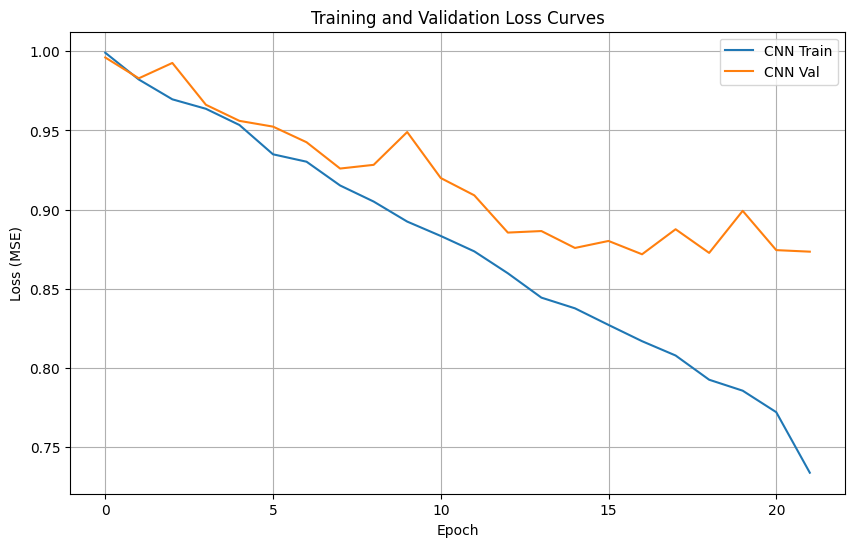

In [28]:
# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming train_loader, val_loader, criterion are defined

# 1. LSTM
# lstm_model = EcogLSTM(input_size=64, hidden_size=128, num_layers=1, output_size=3)
# lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
# lstm_train_losses, lstm_val_losses = train_model(lstm_model, train_loader, val_loader, criterion, lstm_optimizer, device, epochs=20, model_name="LSTM")

# 2. CNN
cnn_model = EcogToMotionNet()
criterion = nn.MSELoss()
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3,  weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(cnn_optimizer, mode='min', patience=3, factor=0.5)
cnn_train_losses, cnn_val_losses = train_model(cnn_model, train_loader, val_loader, criterion, cnn_optimizer, device, epochs=40, model_name="CNN", scheduler=scheduler)

# 3. Linear
# input_channels = X.shape[2]
# sequence_length = X.shape[1]
# linear_model = LinearEcogToMotionNet(input_channels, sequence_length)
# linear_optimizer = torch.optim.Adam(linear_model.parameters(), lr=1e-3)
# linear_train_losses, linear_val_losses = train_model(linear_model, train_loader, val_loader, criterion, linear_optimizer, device, epochs=20, model_name="Linear")

# Plot all losses together
plot_losses({
    # "LSTM": (lstm_train_losses, lstm_val_losses),
    "CNN": (cnn_train_losses, cnn_val_losses),
    # "Linear": (linear_train_losses, linear_val_losses)
})

